# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

## Project Overview

The purpose of this project is to analyze customer data from Megaline's two prepaid plans (Surf and Ultimate) to determine which plan generates more revenue. I will:

1. Load and explore data from multiple sources (users, calls, messages, internet usage, and plans)
2. Clean and prepare the data for analysis
3. Calculate monthly usage and revenue for each customer
4. Analyze customer behavior patterns across different plans
5. Test statistical hypotheses about revenue differences between plans and regions
6. Draw conclusions to help the commercial department make data-driven decisions

## Initialization

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

## Load data

In [2]:
# Load the data files into different DataFrames
plans = pd.read_csv('../data/megaline_plans.csv')
users = pd.read_csv('../data/megaline_users.csv')
calls = pd.read_csv('../data/megaline_calls.csv')
messages = pd.read_csv('../data/megaline_messages.csv')
internet = pd.read_csv('../data/megaline_internet.csv')

## Prepare the data

## Plans

In [3]:
# Print the general/summary information about the plans' DataFrame
print(plans.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes
None


In [4]:
# Print a sample of data for plans
print(plans)

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


### Observations about Plans data:

The plans dataset contains information about two plans: Surf and Ultimate. All data types appear appropriate (numeric values for prices and limits, string for plan name). There are no missing values.

Key observations:
- Surf plan: 20 dollars/month with 500 minutes, 50 messages, 15360 MB (15 GB) included
- Ultimate plan: 70 dollars/month with 3000 minutes, 1000 messages, 30720 MB (30GB) included
- Overage charges are lower for Ultimate plan (0.01 vs 0.03 per minute/message, 7 dollars vs 10 dollars per GB)

## Fix data

In [5]:
# No fixes needed for plans data

## Enrich data

In [6]:
# Add a column for GB/month included with each plan
plans['gb_per_month_included'] = plans['mb_per_month_included'] / 1024
print(plans)

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  \
0               20          10             0.03            0.03      surf   
1               70           7             0.01            0.01  ultimate   

   gb_per_month_included  
0                   15.0  
1                   30.0  


## Users

In [7]:
# Print the general/summary information about the users' DataFrame
print(users.info())
print()
print(users.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None

           user_id         age
count   500.000000  500.000000
mean   1249.500000   45.486000
std     144.481833   16.972269
min    1000.000000   18.000000
25%    1124.750000   30.000000
50%    1249.500000   46.000000
75%    1374.250000   61.000000
max    1499.000000   75.000000


In [8]:
# Print a sample of data for users
print(users.head(10))
print(f'\nTotal users: {len(users)}')
print(f"\nPlan distribution:\n{users['plan'].value_counts()}")

   user_id first_name  last_name  age                                    city  \
0     1000   Anamaria      Bauer   45   Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28         Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36    Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                           Tulsa, OK MSA   
4     1004    Leonila   Thompson   40         Seattle-Tacoma-Bellevue, WA MSA   
5     1005      Livia    Shields   31     Dallas-Fort Worth-Arlington, TX MSA   
6     1006     Jesusa   Bradford   73  San Francisco-Oakland-Berkeley, CA MSA   
7     1007    Eusebio      Welch   42           Grand Rapids-Kentwood, MI MSA   
8     1008      Emely    Hoffman   53       Orlando-Kissimmee-Sanford, FL MSA   
9     1009      Gerry     Little   19  San Jose-Sunnyvale-Santa Clara, CA MSA   

     reg_date      plan  churn_date  
0  2018-12-24  ultimate         NaN  
1  2018-08-13      surf         

### Observations about Users data:

The users dataset contains 500 records with user demographics and plan information. 

Issues identified:
1. Date columns (reg_date and churn_date) are stored as objects instead of datetime format
2. The churn_date column has many missing values (users who haven't churned), which is expected
3. Most users are on the Surf plan

### Fix Data

In [9]:
# Convert date columns to datetime format
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
None


### Enrich Data

In [10]:
# Create a simpler city category to identify NY-NJ area for hypothesis testing
users['is_ny_nj'] = users['city'].str.contains('NY-NJ', na=False)
print(users.info())
print(f"\nUsers in NY-NJ area: {users['is_ny_nj'].sum()}")
print(f"Users in other areas: {(~users['is_ny_nj']).sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
 8   is_ny_nj    500 non-null    bool          
dtypes: bool(1), datetime64[ns](2), int64(2), object(4)
memory usage: 31.9+ KB
None

Users in NY-NJ area: 80
Users in other areas: 420


## Calls

In [11]:
# Print the general/summary information about the calls' DataFrame
print(calls.info())
print()
print(calls.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None

             user_id       duration
count  137735.000000  137735.000000
mean     1247.658046       6.745927
std       139.416268       5.839241
min      1000.000000       0.000000
25%      1128.000000       1.290000
50%      1247.000000       5.980000
75%      1365.000000      10.690000
max      1499.000000      37.600000


In [12]:
# Print a sample of data for calls
print(calls.head(10))

         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22
5  1000_388     1000  2018-12-31      2.20
6  1000_510     1000  2018-12-27      5.75
7  1000_521     1000  2018-12-28     14.18
8  1000_530     1000  2018-12-28      5.77
9  1000_544     1000  2018-12-26      4.40


### Observations about Calls data:

The calls dataset contains individual call records with user_id, call_date, and duration (in minutes).

Issues identified:
1. The call_date column is stored as object type instead of datetime
2. Duration appears to be in minutes with decimal values
3. Zero duration calls will be billed as 1 minute

### Fix data

In [13]:
# Convert call_date to datetime format
calls['call_date'] = pd.to_datetime(calls['call_date'])

#Replace 0-duration calls with 1 minute
calls.loc[calls['duration'] == 0, 'duration'] = 1

print(calls.info())
print()
print('Duration statistics after correction:')
print(calls['duration'].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB
None

Duration statistics after correction:
count    137735.000000
mean          6.940750
std           5.623616
min           0.010000
25%           1.290000
50%           5.980000
75%          10.690000
max          37.600000
Name: duration, dtype: float64


### Enrich data

In [14]:
# Extract month from call_date for aggregation
calls['month'] = calls['call_date'].dt.to_period('M')

# Round up call duration to nearest minute (what the user would be billed for)
calls['duration_rounded'] = np.ceil(calls['duration'])

print(calls.head(10))

         id  user_id  call_date  duration    month  duration_rounded
0   1000_93     1000 2018-12-27      8.52  2018-12               9.0
1  1000_145     1000 2018-12-27     13.66  2018-12              14.0
2  1000_247     1000 2018-12-27     14.48  2018-12              15.0
3  1000_309     1000 2018-12-28      5.76  2018-12               6.0
4  1000_380     1000 2018-12-30      4.22  2018-12               5.0
5  1000_388     1000 2018-12-31      2.20  2018-12               3.0
6  1000_510     1000 2018-12-27      5.75  2018-12               6.0
7  1000_521     1000 2018-12-28     14.18  2018-12              15.0
8  1000_530     1000 2018-12-28      5.77  2018-12               6.0
9  1000_544     1000 2018-12-26      4.40  2018-12               5.0


## Messages

In [15]:
# Print the general/summary information about the messages' DataFrame
print(messages.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None


In [16]:
# Print a sample of data for messages
print(messages.head(10))

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26
5  1000_346     1000   2018-12-29
6  1000_386     1000   2018-12-30
7  1000_413     1000   2018-12-31
8  1000_502     1000   2018-12-27
9  1000_525     1000   2018-12-28


### Observations about Messages data:

The messages dataset contains individual message records with user_id and message_date. Each row represents one message sent.

Issues identified:
1. The message_date column is stored as object type instead of datetime

### Fix data

In [17]:
# Convert message_date to datetime format
messages['message_date'] = pd.to_datetime(messages['message_date'])
print(messages.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB
None


### Enrich data

In [18]:
# Extract month from message_date for aggregation
messages['month'] = messages['message_date'].dt.to_period('M')
print(messages.head(10))

         id  user_id message_date    month
0  1000_125     1000   2018-12-27  2018-12
1  1000_160     1000   2018-12-31  2018-12
2  1000_223     1000   2018-12-31  2018-12
3  1000_251     1000   2018-12-27  2018-12
4  1000_255     1000   2018-12-26  2018-12
5  1000_346     1000   2018-12-29  2018-12
6  1000_386     1000   2018-12-30  2018-12
7  1000_413     1000   2018-12-31  2018-12
8  1000_502     1000   2018-12-27  2018-12
9  1000_525     1000   2018-12-28  2018-12


## Internet

In [19]:
# Print the general/summary information about the internet DataFrame
print(internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None


In [20]:
# Print a sample of data for the internet traffic
print(internet.head(10))

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22
5    1001_0     1001   2018-08-24   284.68
6    1001_3     1001   2018-12-09   656.04
7    1001_4     1001   2018-11-04    16.97
8   1001_10     1001   2018-11-27   135.18
9   1001_15     1001   2018-12-13   761.92


### Observations about Internet data:

The internet dataset contains internet session records with user_id, session_date, and mb_used (megabytes).

Issues identified:
1. The session_date column is stored as object type instead of datetime
2. Data is in MB, but plan pricing is per GB
3. Some sessions show 0 MB used

### Fix data

In [21]:
# Convert session_date to datetime format
internet['session_date'] = pd.to_datetime(internet['session_date'])
print(internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB
None


### Enrich data

In [22]:
# Extract month from session_date for aggregation
internet['month'] = internet['session_date'].dt.to_period('M')

# Convert MB to GB for easier comparison with plan limits
internet['gb_used'] = internet['mb_used'] / 1024

print(internet.head(10))

         id  user_id session_date  mb_used    month   gb_used
0   1000_13     1000   2018-12-29    89.86  2018-12  0.087754
1  1000_204     1000   2018-12-31     0.00  2018-12  0.000000
2  1000_379     1000   2018-12-28   660.40  2018-12  0.644922
3  1000_413     1000   2018-12-26   270.99  2018-12  0.264639
4  1000_442     1000   2018-12-27   880.22  2018-12  0.859590
5    1001_0     1001   2018-08-24   284.68  2018-08  0.278008
6    1001_3     1001   2018-12-09   656.04  2018-12  0.640664
7    1001_4     1001   2018-11-04    16.97  2018-11  0.016572
8   1001_10     1001   2018-11-27   135.18  2018-11  0.132012
9   1001_15     1001   2018-12-13   761.92  2018-12  0.744062


## Study plan conditions

In [23]:
# Print out the plan conditions and make sure they are clear for you
for i in range(len(plans)):
    print(f"\n{plans.iloc[i]['plan_name'].upper()} Plan:")
    print(f"  Monthly fee: ${plans.iloc[i]['usd_monthly_pay']}")
    print(f"  Included minutes: {plans.iloc[i]['minutes_included']}")
    print(f"  Included messages: {plans.iloc[i]['messages_included']}")
    print(f"  Included data: {plans.iloc[i]['gb_per_month_included']:.1f} GB")
    print(f"  Overage cost per minute: ${plans.iloc[i]['usd_per_minute']}")
    print(f"  Overage cost per message: ${plans.iloc[i]['usd_per_message']}")
    print(f"  Overage cost per GB: ${plans.iloc[i]['usd_per_gb']}")


SURF Plan:
  Monthly fee: $20
  Included minutes: 500
  Included messages: 50
  Included data: 15.0 GB
  Overage cost per minute: $0.03
  Overage cost per message: $0.03
  Overage cost per GB: $10

ULTIMATE Plan:
  Monthly fee: $70
  Included minutes: 3000
  Included messages: 1000
  Included data: 30.0 GB
  Overage cost per minute: $0.01
  Overage cost per message: $0.01
  Overage cost per GB: $7


## Aggregate data per user

In [24]:
# Calculate the number of calls made by each user per month. Save the result.
calls_per_month = calls.groupby(['user_id', 'month']).agg(num_calls=('id', 'count')).reset_index()
print(calls_per_month.head(10))

   user_id    month  num_calls
0     1000  2018-12         16
1     1001  2018-08         27
2     1001  2018-09         49
3     1001  2018-10         65
4     1001  2018-11         64
5     1001  2018-12         56
6     1002  2018-10         11
7     1002  2018-11         55
8     1002  2018-12         47
9     1003  2018-12        149


In [25]:
# Calculate the amount of minutes spent by each user per month. Save the result.
minutes_per_month = calls.groupby(['user_id', 'month']).agg(total_minutes=('duration_rounded', 'sum')).reset_index()
print(minutes_per_month.head(10))

   user_id    month  total_minutes
0     1000  2018-12          124.0
1     1001  2018-08          187.0
2     1001  2018-09          326.0
3     1001  2018-10          411.0
4     1001  2018-11          441.0
5     1001  2018-12          422.0
6     1002  2018-10           62.0
7     1002  2018-11          393.0
8     1002  2018-12          393.0
9     1003  2018-12         1135.0


In [26]:
# Calculate the number of messages sent by each user per month. Save the result.
messages_per_month = messages.groupby(['user_id', 'month']).agg(num_messages=('id', 'count')).reset_index()
print(messages_per_month.head(10))

   user_id    month  num_messages
0     1000  2018-12            11
1     1001  2018-08            30
2     1001  2018-09            44
3     1001  2018-10            53
4     1001  2018-11            36
5     1001  2018-12            44
6     1002  2018-10            15
7     1002  2018-11            32
8     1002  2018-12            41
9     1003  2018-12            50


In [27]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet_per_month = internet.groupby(['user_id', 'month']).agg(total_mb=('mb_used', 'sum'), total_gb=('gb_used', 'sum')).reset_index()

# Round up GB to nearest whole number (what the user would be billed for)
internet_per_month['gb_rounded'] = np.ceil(internet_per_month['total_gb'])

print(internet_per_month.head(10))

   user_id    month  total_mb   total_gb  gb_rounded
0     1000  2018-12   1901.47   1.856904         2.0
1     1001  2018-08   6919.15   6.756982         7.0
2     1001  2018-09  13314.82  13.002754        14.0
3     1001  2018-10  22330.49  21.807119        22.0
4     1001  2018-11  18504.30  18.070605        19.0
5     1001  2018-12  19369.18  18.915215        19.0
6     1002  2018-10   6552.01   6.398447         7.0
7     1002  2018-11  19345.08  18.891680        19.0
8     1002  2018-12  14396.24  14.058828        15.0
9     1003  2018-12  27044.14  26.410293        27.0


In [28]:
# Merge the data for calls, minutes, messages, internet based on user_id and month

# First, merge calls data (which includes both number of calls and minutes)
user_month_data = calls_per_month.merge(minutes_per_month, on=['user_id', 'month'], how='outer')

# Merge messages
user_month_data = user_month_data.merge(messages_per_month, on=['user_id', 'month'], how='outer')

# Merge internet
user_month_data = user_month_data.merge(internet_per_month, on=['user_id', 'month'], how='outer')

# Fill NaN values with 0 (users who didn't use a service that month)
user_month_data = user_month_data.fillna(0)

user_month_data.info()
print()
print(user_month_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype    
---  ------         --------------  -----    
 0   user_id        2293 non-null   int64    
 1   month          2293 non-null   period[M]
 2   num_calls      2293 non-null   float64  
 3   total_minutes  2293 non-null   float64  
 4   num_messages   2293 non-null   float64  
 5   total_mb       2293 non-null   float64  
 6   total_gb       2293 non-null   float64  
 7   gb_rounded     2293 non-null   float64  
dtypes: float64(6), int64(1), period[M](1)
memory usage: 143.4 KB

   user_id    month  num_calls  total_minutes  num_messages  total_mb  \
0     1000  2018-12       16.0          124.0          11.0   1901.47   
1     1001  2018-08       27.0          187.0          30.0   6919.15   
2     1001  2018-09       49.0          326.0          44.0  13314.82   
3     1001  2018-10       65.0          411.0          53.0  22330.49   
4 

In [29]:
# Add the plan information

# First, add user information
user_month_data = user_month_data.merge(users[['user_id', 'plan', 'reg_date', 'churn_date', 'is_ny_nj', 'city']], on='user_id', how='left')

# Add plan details
user_month_data = user_month_data.merge(plans, left_on='plan', right_on='plan_name', how='left')

user_month_data.info()
print()
print(user_month_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                2293 non-null   int64         
 1   month                  2293 non-null   period[M]     
 2   num_calls              2293 non-null   float64       
 3   total_minutes          2293 non-null   float64       
 4   num_messages           2293 non-null   float64       
 5   total_mb               2293 non-null   float64       
 6   total_gb               2293 non-null   float64       
 7   gb_rounded             2293 non-null   float64       
 8   plan                   2293 non-null   object        
 9   reg_date               2293 non-null   datetime64[ns]
 10  churn_date             158 non-null    datetime64[ns]
 11  is_ny_nj               2293 non-null   bool          
 12  city                   2293 non-null   object        
 13  mes

In [30]:
# Calculate the monthly revenue for each user
# Revenue = monthly fee + overage charges for minutes, messages, and data

#Calculate overage for each service (overage = max(0, used - included))
user_month_data['minutes_overage'] = np.maximum(0, user_month_data['total_minutes'] - user_month_data['minutes_included'])
user_month_data['messages_overage'] = np.maximum(0, user_month_data['num_messages'] - user_month_data['messages_included'])
user_month_data['gb_overage'] = np.maximum(0, user_month_data['gb_rounded'] - user_month_data['gb_per_month_included'])

# Calculate overage charges
user_month_data['minutes_overage_charge'] = user_month_data['minutes_overage'] * user_month_data['usd_per_minute']
user_month_data['messages_overage_charge'] = user_month_data['messages_overage'] * user_month_data['usd_per_message']
user_month_data['gb_overage_charge'] = user_month_data['gb_overage'] * user_month_data['usd_per_gb']

# Calculate total monthly revenue
user_month_data['monthly_revenue'] = (user_month_data['usd_monthly_pay'] + user_month_data['minutes_overage_charge'] + user_month_data['messages_overage_charge'] + user_month_data['gb_overage_charge'])

print(user_month_data[['user_id', 'month', 'usd_monthly_pay', 'minutes_overage_charge', 'messages_overage_charge', 'gb_overage_charge', 'monthly_revenue']].head(10))

   user_id    month  usd_monthly_pay  minutes_overage_charge  \
0     1000  2018-12               70                    0.00   
1     1001  2018-08               20                    0.00   
2     1001  2018-09               20                    0.00   
3     1001  2018-10               20                    0.00   
4     1001  2018-11               20                    0.00   
5     1001  2018-12               20                    0.00   
6     1002  2018-10               20                    0.00   
7     1002  2018-11               20                    0.00   
8     1002  2018-12               20                    0.00   
9     1003  2018-12               20                   19.05   

   messages_overage_charge  gb_overage_charge  monthly_revenue  
0                     0.00                0.0            70.00  
1                     0.00                0.0            20.00  
2                     0.00                0.0            20.00  
3                     0.09         

## Study user behaviour

### Calls

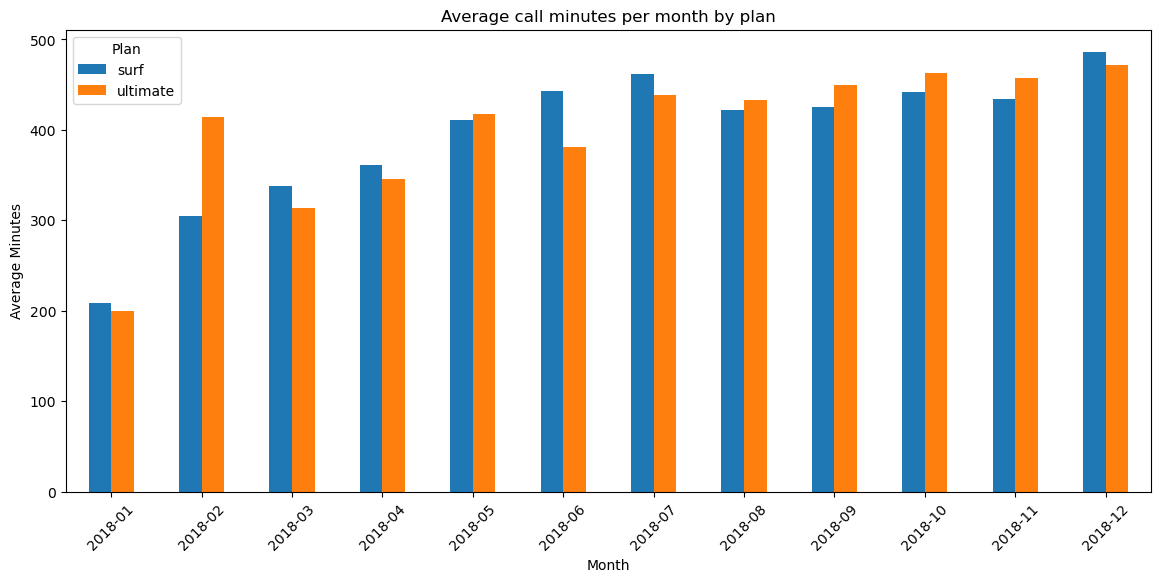

In [32]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.
avg_minutes_by_plan_month = user_month_data.groupby(['plan', 'month'])['total_minutes'].mean().reset_index()

# Create a pivot table for easier plotting
pivot_minutes = avg_minutes_by_plan_month.pivot(index='month', columns='plan', values='total_minutes')

# Plot bar chart
pivot_minutes.plot(kind='bar', title='Average call minutes per month by plan', xlabel='Month', ylabel='Average Minutes', rot=45, figsize=(14,6))
plt.legend(title='Plan')
plt.show()

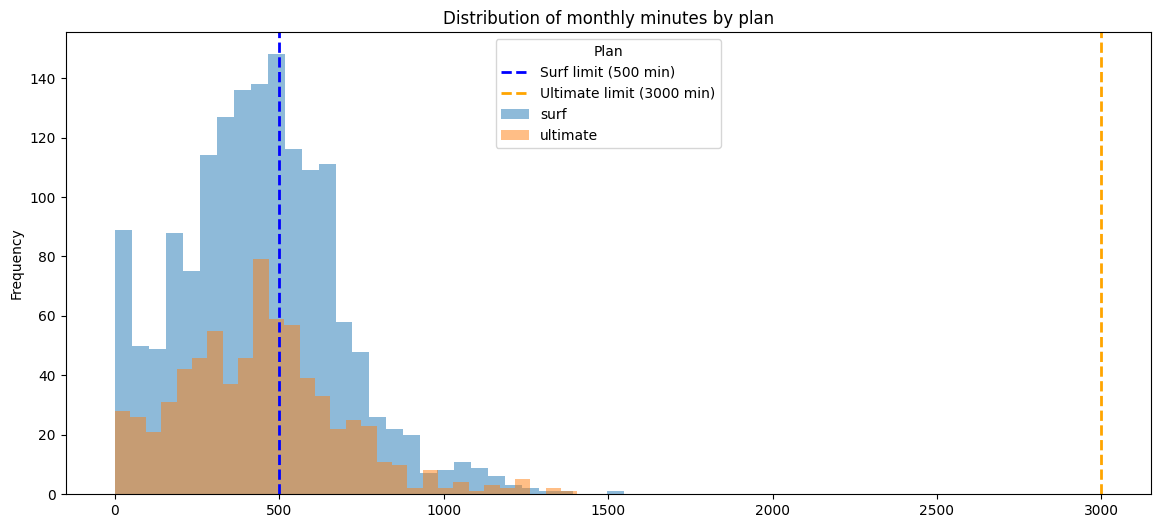

In [ ]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
user_month_data.groupby('plan')['total_minutes'].plot(kind='hist', bins=30, alpha=0.5, title='Distribution of monthly minutes by plan',xlabel='Minutes', ylabel='Frequency', figsize=(14,6), legend=True)
plt.axvline(500, color='blue', linestyle='--', label='Surf limit (500 min)', linewidth=2)
plt.axvline(3000, color='orange', linestyle='--', label='Ultimate limit (3000 min)', linewidth=2)
plt.legend(title='Plan')
plt.show()

In [ ]:
# Calculate the mean and the variance of the monthly call duration
call_stats = user_month_data.groupby('plan')['total_minutes'].agg(['mean', 'var', 'std', 'median'])
call_stats

,mean,var,std,median
plan,,,,
surf,440.324221,57743.745959,240.299284,438.0
ultimate,442.431944,60876.012052,246.730647,437.5


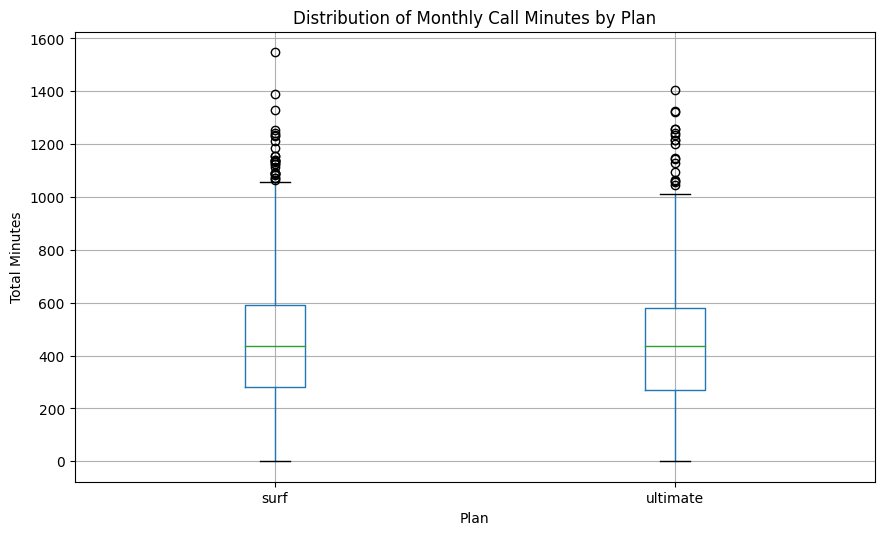

In [ ]:
# Plot a boxplot to visualize the distribution of the monthly call duration
user_month_data.boxplot(column='total_minutes', by='plan', figsize=(10, 6))
plt.title('Distribution of Monthly Call Minutes by Plan')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('Total Minutes')
plt.show()

### Conclusions on call behavior:

Based on the analysis of call data:
1. Despite Ultimate offering 3000 minutes vs Surf's 500 minutes, users consume similar amounts
2. This suggests people choose plans based on perceived needs or risk aversion rather than actual usage patterns
3. Ultimate users are significantly under-utilizing their allowance

### Messages

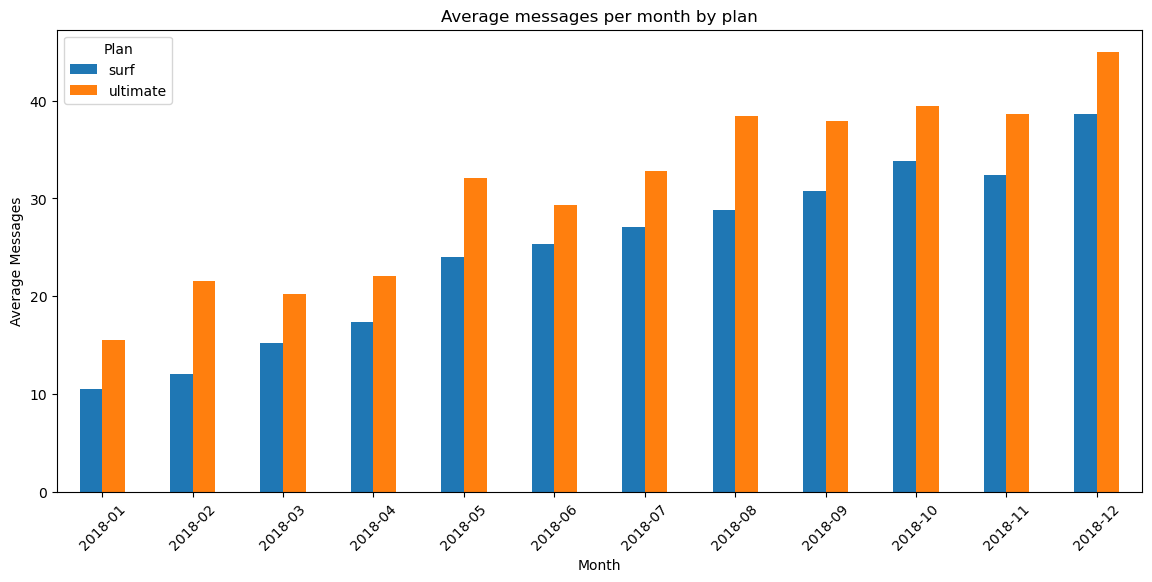

In [34]:
# Compare the number of messages users of each plan tend to send each month
avg_messages_by_plan_month = user_month_data.groupby(['plan', 'month'])['num_messages'].mean().reset_index()

# Create a pivot table for easier plotting
pivot_messages = avg_messages_by_plan_month.pivot(index='month', columns='plan', values='num_messages')

# Plot bar chart
pivot_messages.plot(kind='bar', title='Average messages per month by plan', xlabel='Month', ylabel='Average Messages', rot=45, figsize=(14,6))
plt.legend(title='Plan')
plt.show()

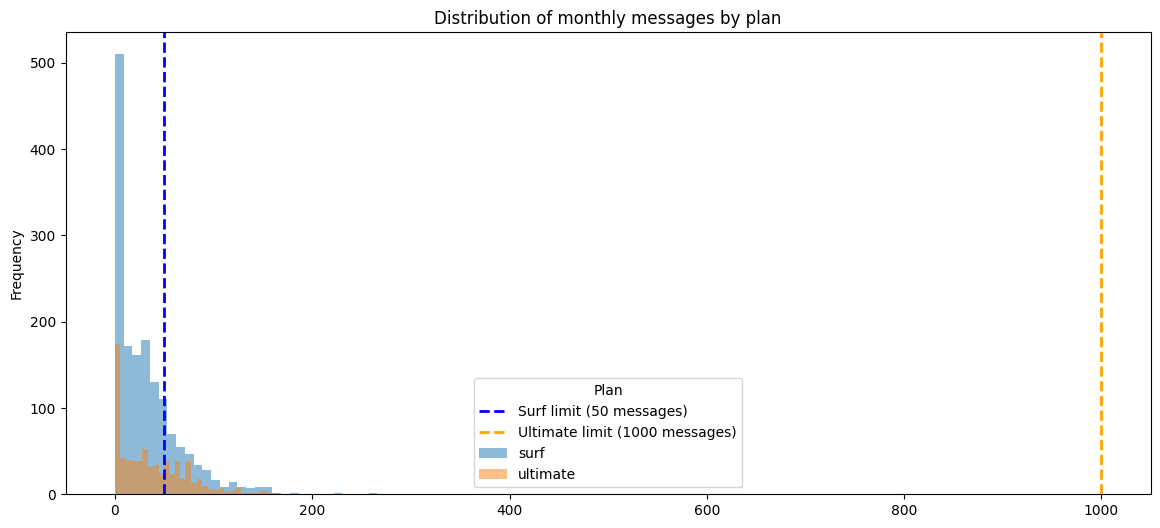

In [ ]:
# Compare the number of messages users of each plan require each month. Plot a histogram.
user_month_data.groupby('plan')['num_messages'].plot(kind='hist', bins=30, alpha=0.5, title='Distribution of monthly messages by plan',xlabel='Messages', ylabel='Frequency', figsize=(14,6), legend=True)
plt.axvline(50, color='blue', linestyle='--', label='Surf limit (50 messages)', linewidth=2)
plt.axvline(1000, color='orange', linestyle='--', label='Ultimate limit (1000 messages)', linewidth=2)
plt.legend(title='Plan')
plt.show()

In [ ]:
# Calculate the mean and the variance of the monthly messages
message_stats = user_month_data.groupby('plan')['num_messages'].agg(['mean', 'var', 'std', 'median'])
message_stats

,mean,var,std,median
plan,,,,
surf,31.159568,1126.724522,33.566717,24.0
ultimate,37.551389,1208.756744,34.767179,30.0


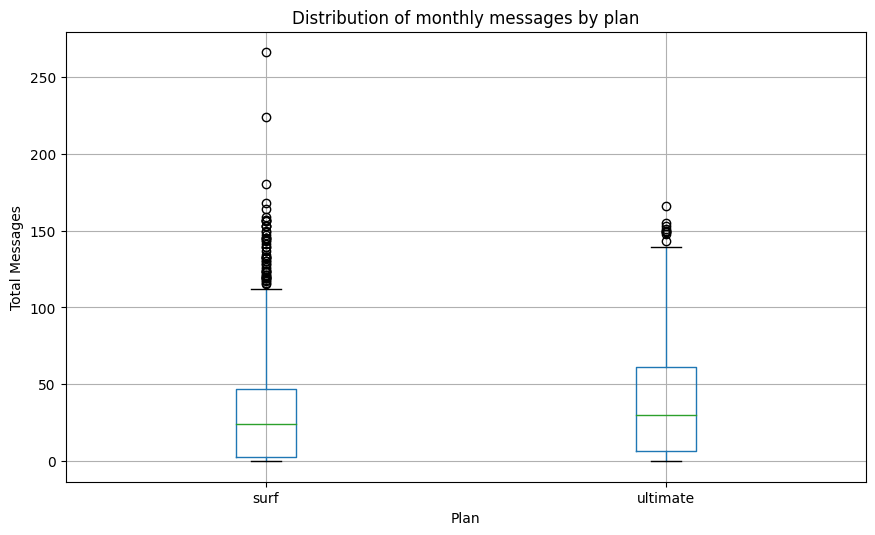

In [ ]:
# Plot a boxplot to visualize the distribution of monthly messages
user_month_data.boxplot(column='num_messages', by='plan', figsize=(10, 6))
plt.title('Distribution of monthly messages by plan')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('Total Messages')
plt.show()

### Conclusions on Message Behavior:

Based on the analysis of message data:
1. Both plans show very low usage compared to allowances
2. Plan choice doesn't significantly affect messaging behavior
3. Message allowances are over-provisioned, especially for Ultimate
4. Usage increased throughout 2018

### Internet

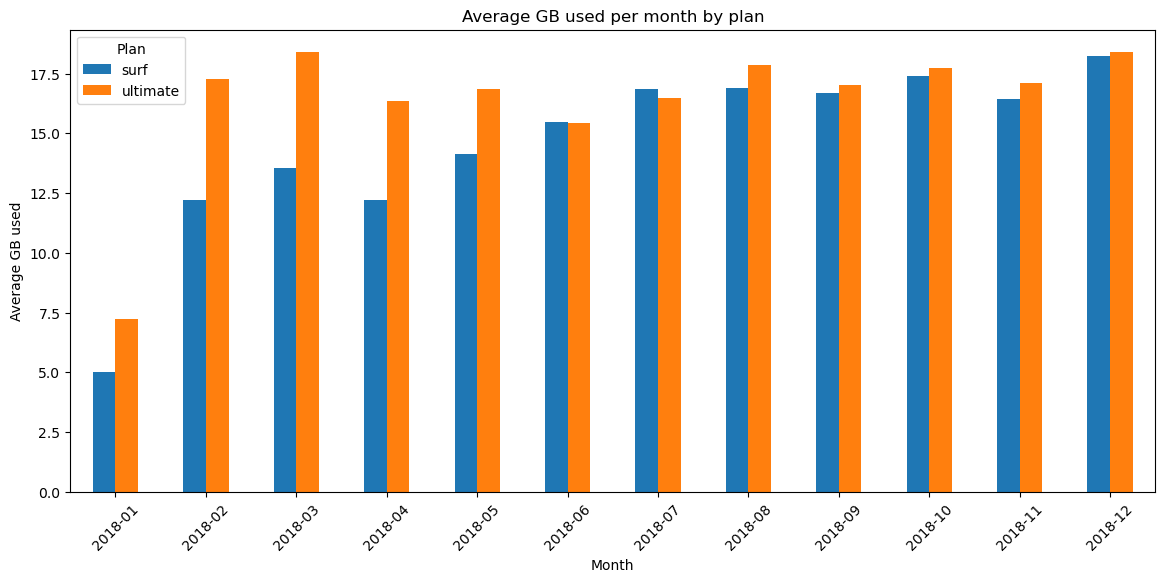

In [35]:
# Compare the internet usage users of each plan tend to use each month
avg_internet_by_plan_month = user_month_data.groupby(['plan', 'month'])['gb_rounded'].mean().reset_index()

# Create a pivot table for easier plotting
pivot_internet = avg_internet_by_plan_month.pivot(index='month', columns='plan', values='gb_rounded')

# Plot bar chart
pivot_internet.plot(kind='bar', title='Average GB used per month by plan', xlabel='Month', ylabel='Average GB used', rot=45, figsize=(14,6))
plt.legend(title='Plan')
plt.show()

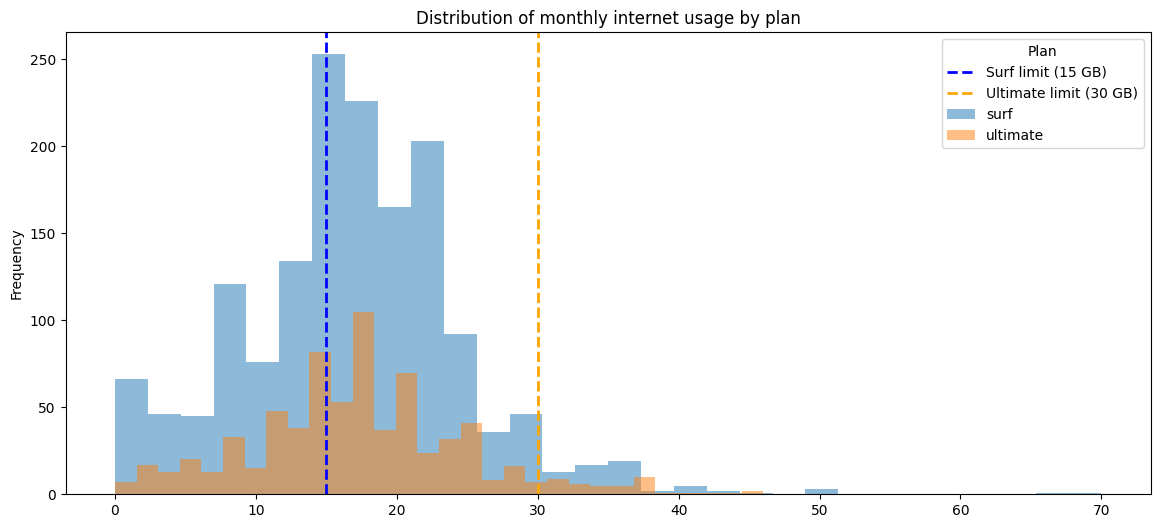

In [ ]:
# Compare the internet usage users of each plan require each month. Plot a histogram.
user_month_data.groupby('plan')['gb_rounded'].plot(kind='hist', bins=30, alpha=0.5, title='Distribution of monthly internet usage by plan',xlabel='GB usage', ylabel='Frequency', figsize=(14,6), legend=True)
plt.axvline(15, color='blue', linestyle='--', label='Surf limit (15 GB)', linewidth=2)
plt.axvline(30, color='orange', linestyle='--', label='Ultimate limit (30 GB)', linewidth=2)
plt.legend(title='Plan')
plt.show()

In [ ]:
# Calculate the mean and the variance of the monthly messages
internet_stats = user_month_data.groupby('plan')['gb_rounded'].agg(['mean', 'var', 'std', 'median'])
internet_stats

,mean,var,std,median
plan,,,,
surf,16.670693,61.58360,7.847522,17.0
ultimate,17.306944,58.83055,7.670108,17.0


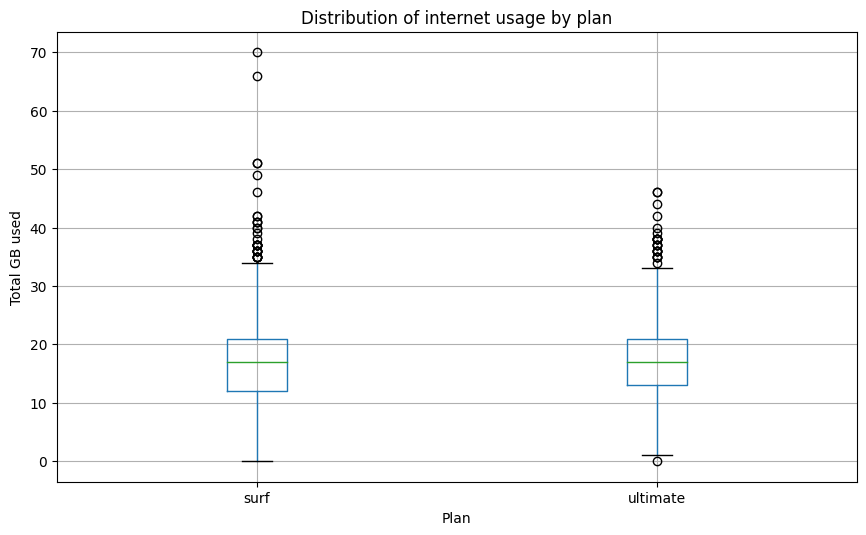

In [ ]:
# Plot a boxplot to visualize the distribution of monthly internet usage
user_month_data.boxplot(column='gb_rounded', by='plan', figsize=(10, 6))
plt.title('Distribution of internet usage by plan')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('Total GB used')
plt.show()

### Conclusions on Internet Usage Behavior:

Based on the analysis of internet usage data:
1. Nearly identical usage patterns across both plans
2. Surf users frequently exceed their allowance
3. Ultimate users stay well within their limit

## Revenue

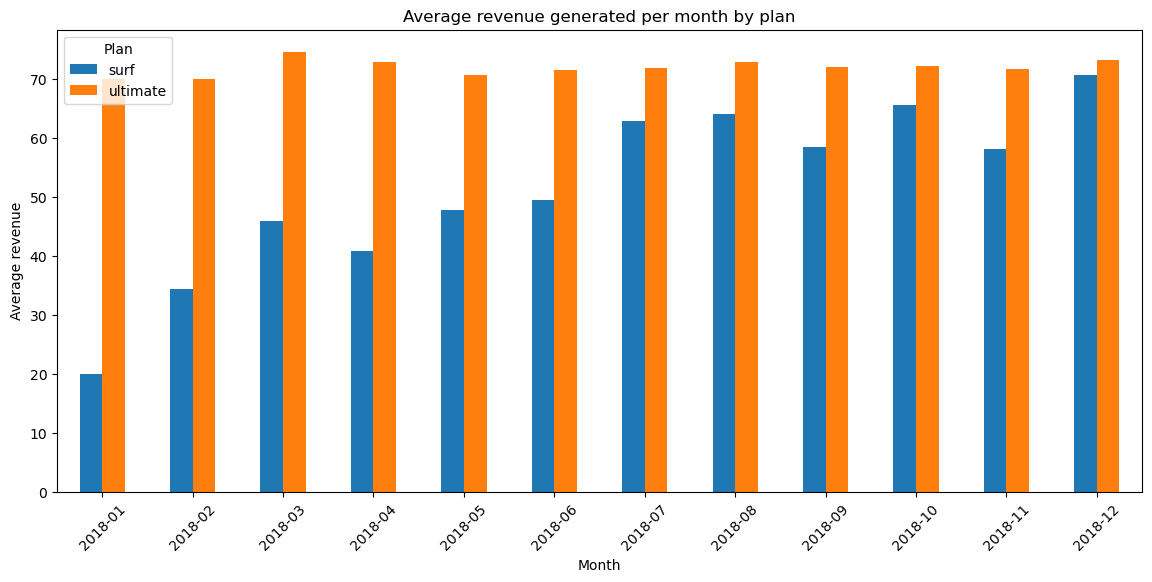

In [36]:
# Compare the revenue each plan tends to generate each month
avg_revenue_by_plan_month = user_month_data.groupby(['plan', 'month'])['monthly_revenue'].mean().reset_index()

# Create a pivot table for easier plotting
pivot_revenue = avg_revenue_by_plan_month.pivot(index='month', columns='plan', values='monthly_revenue')

# Plot bar chart
pivot_revenue.plot(kind='bar', title='Average revenue generated per month by plan', xlabel='Month', ylabel='Average revenue', rot=45, figsize=(14,6))
plt.legend(title='Plan')
plt.show()

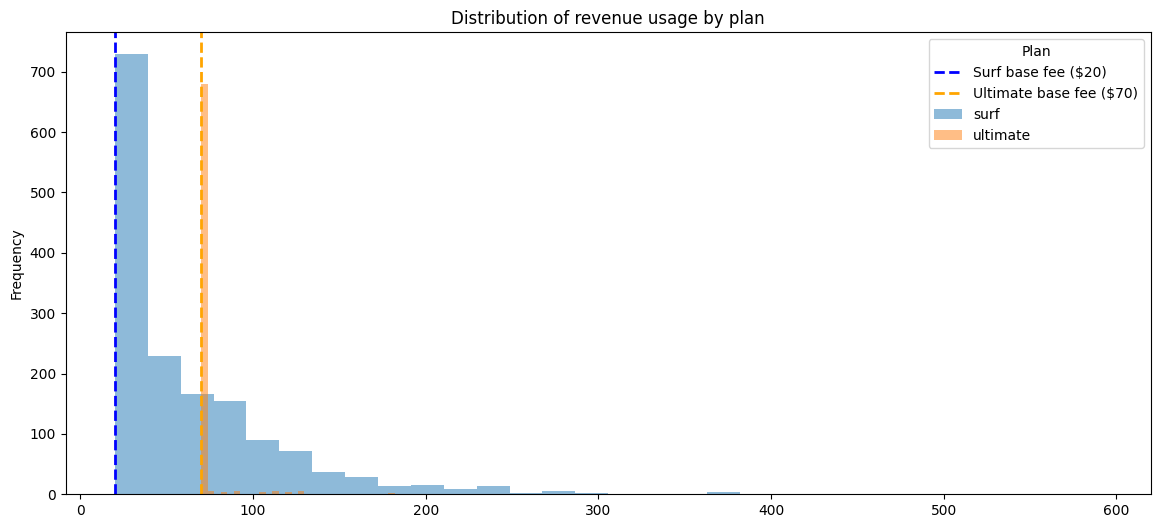

In [ ]:
# Compare the revenue generated by users for each plan. Plot a histogram.
user_month_data.groupby('plan')['monthly_revenue'].plot(kind='hist', bins=30, alpha=0.5, title='Distribution of revenue usage by plan',xlabel='Monthly Revenue ($)', ylabel='Frequency', figsize=(14,6), legend=True)
plt.axvline(20, color='blue', linestyle='--', label='Surf base fee ($20)', linewidth=2)
plt.axvline(70, color='orange', linestyle='--', label='Ultimate base fee ($70)', linewidth=2)
plt.legend(title='Plan')
plt.show()

In [ ]:
# Calculate the mean and the variance of the revenue
revenue_stats = user_month_data.groupby('plan')['monthly_revenue'].agg(['mean', 'var', 'std', 'median'])
revenue_stats

,mean,var,std,median
plan,,,,
surf,60.899053,3075.367902,55.456000,40.42
ultimate,72.313889,129.848486,11.395108,70.00


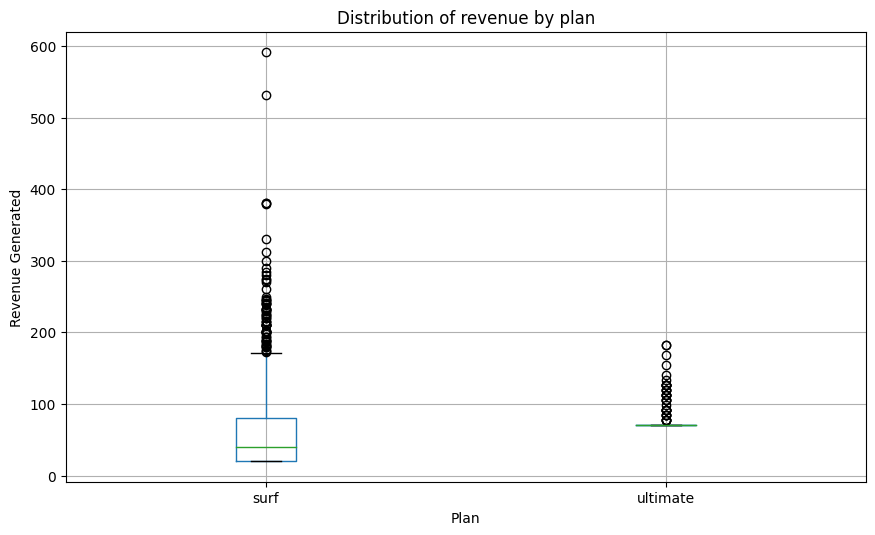

In [ ]:
# Plot a boxplot to visualize the distribution of monthly revenue
user_month_data.boxplot(column='monthly_revenue', by='plan', figsize=(10, 6))
plt.title('Distribution of revenue by plan')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('Revenue Generated')
plt.show()

## Revenue Analysis Summary:

**1. Ultimate generates more revenue per user:**
- Ultimate average: 72.31 dollars per month vs Surf average: 60.71 dollars per month (19 percent higher)
- Ultimate is more profitable per customer

**2. Surf revenue is unpredictable due to overage charges:**
- Surf median (40.36 dollars) is double the 20 dollar base fee - most users pay overage charges
- High variability (standard deviation: 55.39 dollars) means bills fluctuate significantly month-to-month
- Primary driver: data overages from exceeding the 15 GB limit

**3. Ultimate revenue is stable and predictable:**
- Ultimate median (70.00 dollars) matches the base fee - most users do not pay overages
- Low variability (standard deviation: 11.40 dollars) means consistent monthly bills
- Users stay within their allowances, generating reliable revenue

**4. Revenue increased throughout 2018:**
- Surf revenue tripled from about 20 dollars to 70 dollars as data usage and overages grew
- Ultimate remained stable at 65 to 75 dollars throughout the year
- By December, both plans generated similar revenue (about 70 to 75 dollars per month)

## Test statistical hypotheses

### Hypothesis 1: Average revenue from Ultimate and Surf plans differs

**Hypotheses:**
- **Null hypothesis (H₀):** The average revenue from users of Ultimate and Surf calling plans is equal
- **Alternative hypothesis (H₁):** The average revenue from users of Ultimate and Surf calling plans differs

**Statistical test:** Two-sample t-test (independent samples) using `scipy.stats.ttest_ind()`

**Significance level:** α = 0.05 (critical statistical significance level)

**Reasoning:** We use a two-sample t-test because we are comparing the means of two independent groups (Surf users vs Ultimate users). We'll first check the variances of both groups to determine whether to set `equal_var=True` or `equal_var=False`.

To ensure the independence assumption of the t-test is satisfied, I first aggregated the data to the user level. For each user, I calculated their average monthly revenue across all 12 months of 2018. This ensures that each observation in the test represents one independent user rather than multiple correlated months from the same user.

In [ ]:
# Calculate average monthly revenue per user
user_avg_revenue = user_month_data.groupby('user_id').agg({'monthly_revenue': 'mean','plan': 'first', 'is_ny_nj': 'first'}).reset_index()

# Rename column for clarity
user_avg_revenue.rename(columns={'monthly_revenue': 'avg_monthly_revenue'}, inplace=True)

print(user_avg_revenue.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              490 non-null    int64  
 1   avg_monthly_revenue  490 non-null    float64
 2   plan                 490 non-null    object 
 3   is_ny_nj             490 non-null    bool   
dtypes: bool(1), float64(1), int64(1), object(1)
memory usage: 12.1+ KB
None


In [ ]:
# Extract revenue data for each plan
surf_revenue = user_avg_revenue[user_avg_revenue['plan'] == 'surf']['avg_monthly_revenue']
ultimate_revenue = user_avg_revenue[user_avg_revenue['plan'] == 'ultimate']['avg_monthly_revenue']

# Set significance level
alpha = 0.05

# Check variances to decide on equal_var parameter
print('Variance check:')
print(f'Surf variance: {surf_revenue.var():.2f}')
print(f'Ultimate variance: {ultimate_revenue.var():.2f}')
print(f'Variance ratio: {surf_revenue.var() / ultimate_revenue.var():.2f}')
print()

Variance check:
Surf variance: 1902.16
Ultimate variance: 55.13
Variance ratio: 34.51



In [ ]:
# Perform two-sample t-test
# Since variances appear different, we set equal_var=False
results = st.ttest_ind(surf_revenue, ultimate_revenue, equal_var=False)

print(f'Surf plan - Mean revenue: ${surf_revenue.mean():.2f}')
print(f'Ultimate plan - Mean revenue: ${ultimate_revenue.mean():.2f}')
print()
print(f'p-value: {results.pvalue}')
print()

if results.pvalue < alpha:
    print("We reject the null hypothesis")
    print('Conclusion: There IS a statistically significant difference in average revenue')
    print('between the Surf and Ultimate plans.')
else:
    print("We can't reject the null hypothesis")
    print('Conclusion: There is NO statistically significant difference in average revenue')
    print('between the Surf and Ultimate plans.')

Surf plan - Mean revenue: $58.38
Ultimate plan - Mean revenue: $71.82

p-value: 8.692101224680108e-08

We reject the null hypothesis
Conclusion: There IS a statistically significant difference in average revenue
between the Surf and Ultimate plans.


### Hypothesis 2: Average revenue from NY-NJ area differs from other regions

**Hypotheses:**
- **Null hypothesis (H₀):** The average revenue from users in NY-NJ area is equal to that of users from other regions
- **Alternative hypothesis (H₁):** The average revenue from users in NY-NJ area differs from that of users from other regions

**Statistical test:** Two-sample t-test (independent samples) using `scipy.stats.ttest_ind()`

**Significance level:** α = 0.05 (critical statistical significance level)

**Reasoning:** Similar to the first hypothesis, we use a two-sample t-test to compare means between two independent groups (NY-NJ users vs other region users). We'll check the variances to determine the appropriate `equal_var` parameter.

Similar to Hypothesis 1, I aggregated the data to the user level by calculating each user's average monthly revenue across all months. This aggregation ensures the independence assumption is met, as we're comparing average revenues from distinct users rather than multiple observations from the same users.

In [ ]:
# Extract revenue data for each region
ny_nj_revenue = user_avg_revenue[user_avg_revenue['is_ny_nj'] == True]['avg_monthly_revenue']
other_revenue = user_avg_revenue[user_avg_revenue['is_ny_nj'] == False]['avg_monthly_revenue']

# Set significance level
alpha = 0.05  # critical statistical significance level

# Check variances to decide on equal_var parameter
print('Variance check:')
print(f'NY-NJ variance: {ny_nj_revenue.var():.2f}')
print(f'Other regions variance: {other_revenue.var():.2f}')
print(f'Variance ratio: {ny_nj_revenue.var() / other_revenue.var():.2f}')
print()

Variance check:
NY-NJ variance: 1071.36
Other regions variance: 1402.89
Variance ratio: 0.76



In [ ]:
# Perform two-sample t-test
# We'll set equal_var based on variance comparison
results = st.ttest_ind(ny_nj_revenue, other_revenue, equal_var=True)

print(f'NY-NJ area - Mean revenue: ${ny_nj_revenue.mean():.2f}')
print(f'Other regions - Mean revenue: ${other_revenue.mean():.2f}')
print()
print(f'p-value: {results.pvalue}')
print()

if results.pvalue < alpha:
    print("We reject the null hypothesis")
    print('Conclusion: There IS a statistically significant difference in average revenue')
    print('between NY-NJ area and other regions.')
else:
    print("We can't reject the null hypothesis")
    print('Conclusion: There is NO statistically significant difference in average revenue')
    print('between NY-NJ area and other regions.')

NY-NJ area - Mean revenue: $60.04
Other regions - Mean revenue: $63.19

p-value: 0.48516408450209136

We can't reject the null hypothesis
Conclusion: There is NO statistically significant difference in average revenue
between NY-NJ area and other regions.


## General Conclusion

### Key Findings

This analysis of Megaline's Surf and Ultimate prepaid plans reveals important insights about customer behavior, revenue generation, and strategic opportunities for the business.

#### 1. Revenue Performance

**Ultimate plan generates higher revenue per customer:**
- Ultimate users contribute an average of 71.82 dollars per month compared to Surf users at 58.38 dollars per month (23 percent higher)
- Statistical testing confirms this difference is significant (p-value = 8.692101224680108e-08)

**However, Surf plan dominates in customer volume:**
- Surf attracts 339 users (68 percent of customer base) versus Ultimate's 161 users (32 percent)
- The lower 20 dollar price point makes Surf more attractive for customer acquisition
- By December 2018, Surf revenue converged with Ultimate (both generating approximately 70-75 dollars per month) due to accumulated overage charges

#### 2. Customer Behavior Patterns

**Usage is similar across plans despite different allowances:**
- Call minutes: Both plans average around 440 minutes per month (median values nearly identical)
- Messages: Surf users average 31.2 messages vs Ultimate users at 37.6 messages (minimal difference)
- Internet data: Surf users average 16.7 GB vs Ultimate users at 17.3 GB (only 0.6 GB difference)

**Critical insight:** Customer behavior is driven by personal habits rather than plan limits. Users consume what they need regardless of their allowance.

#### 3. Overage Patterns and Revenue Stability

**Surf plan shows high revenue variability:**
- Median revenue (40.36 dollars) is double the base fee, indicating most users incur overage charges
- High standard deviation (55.39 dollars) means bills fluctuate significantly month-to-month
- Primary driver: data overages from exceeding the 15 GB limit
- Revenue increased throughout 2018 as data usage grew

**Ultimate plan provides stable, predictable revenue:**
- Median revenue (70.00 dollars) matches the base fee exactly - most users stay within allowances
- Low standard deviation (11.40 dollars) indicates consistent monthly bills
- Users are significantly over-provisioned, using less than 60 percent of data allowance and less than 15 percent of minute allowance
- Stable revenue stream throughout 2018 (65-75 dollar range)

#### 4. Regional Differences

- NY-NJ average: 60.04 dollars per month
- Other regions average: 63.19 dollars per month
- Difference: 3.15 dollars per month (5% lower in NY-NJ)
- Statistical testing (p-value = 0.485) indicates this difference is not statistically significant

### Strategic Recommendations

Based on this analysis, I recommend a **dual-strategy approach** rather than focusing exclusively on one plan:

#### Maintain Both Plans with Distinct Positioning

**Ultimate Plan Strategy:**
- Target customers who value predictability and peace of mind
- Position as the premium, worry-free option for heavy users and business customers
- Emphasize stable billing and no surprise charges in marketing
- Continue to provide stable, high-margin revenue stream

**Surf Plan Strategy:**
- Continue using as primary customer acquisition tool due to attractive entry price
- Accept revenue variability as trade-off for higher customer volume
- Monitor customer satisfaction regarding data overage frequency
- Consider as gateway product for eventual upsell to Ultimate

#### Consider Plan Modifications

**Adjust Surf plan data allowance:**
- Current 15 GB limit is increasingly inadequate as average usage approaches 17 GB
- Recommendation: Increase to 18-20 GB to reduce customer frustration while maintaining overage revenue potential
- This could improve customer satisfaction without significantly impacting revenue

**Introduce a mid-tier plan:**
- Create a 40-50 dollar per month option with 1000-1500 minutes and 20-25 GB data
- Capture customers who find Surf too limiting but Ultimate excessive
- Fill the gap between budget-conscious and premium segments

#### Market Segmentation Approach

**Surf Plan:** Budget-conscious users, light-to-moderate users, students, price-sensitive customers

**Mid-tier Plan (if introduced):** Moderate users seeking value without overage risk

**Ultimate Plan:** Heavy users, business customers, those prioritizing bill stability and peace of mind

### Final Recommendation

**Do not focus exclusively on either plan.** Both Surf and Ultimate serve critical but different business purposes:

- **Surf drives customer acquisition** through attractive pricing and captures a larger market share
- **Ultimate maximizes per-customer profitability** and provides revenue stability

The optimal strategy is to maintain both plans while optimizing each for its target customer segment. As data usage continues to grow (as evidenced by the tripling of usage throughout 2018), consider adjusting plan parameters to balance customer satisfaction with revenue generation.

The company should leverage its diverse plan portfolio to serve different customer needs while building a foundation for long-term revenue growth through strategic upselling and plan optimization.